In [1]:
import tensorflow as tf
tf.get_logger().setLevel('ERROR')

import dadi

from dadi import Numerics, PhiManip, Integration, Spectrum
from matplotlib import pyplot as plt
import numpy as np
from pydens import Solver, NumpySampler, add_tokens, plot_loss, plot_2d

import warnings
warnings.filterwarnings('ignore')

add_tokens()


Модель взята из dadi/Demographics1D.py/bottlegrowth_my  
Начальные условия: из PhiManip.py/phi_1D_genic

In [142]:
def pydensIntegrate(xGrid, params):
    tf.get_logger().setLevel('ERROR')

    gamma, theta, nuB, nuA, T = params
    initial_cond = lambda x: nuB * theta/(x*(1-x))*(1-exp(-2*gamma*(1-x)))/(1-exp(-2*gamma))

    one_pop_pde = {'n_dims': 2,
        'form': lambda u, x, t: D(u, t) - 0.5 * D(D(x*(1-x)*u*1/(nuB*exp(log(nuA/nuB) * t/T)), x), x) + D(gamma*x*(1-x)*u, x),
        'boundary_condition': lambda t: [0, 1], 
        'initial_condition': lambda x: initial_cond(x+0.0001)}

    config = {'pde': one_pop_pde,
            'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05}}

    s = NumpySampler('u', dim=2)

    model = Solver(config)
    model.fit(batch_size=40, sampler=s, n_iters=500, bar='notebook')
    
    pts = np.array(list(zip(xGrid, [T]*len(xGrid))))
    dg = model.solve(pts)

    return dg

In [143]:
def plotStat(theta, gamma, nuB, nuA, T):

    print(" Theta:", theta, " gamma:", gamma, " nuB:", nuB, " nuA:", nuA, " T:", T)

    nu_func = lambda t: nuB*np.exp(np.log(nuA/nuB) * t/T)
    xGrid = Numerics.default_grid(500)
    initial_phi = PhiManip.phi_1D(xGrid, nu = nu_func(0), theta0 = theta, gamma = gamma)
    phi_dadi = Integration.one_pop(initial_phi, xGrid, T, nu = nu_func, gamma = gamma, theta0 = theta, beta=1)

    dg = pydensIntegrate(xGrid, (gamma, theta, nuB, nuA, T))

    plt.plot(xGrid[2:], dg[2:], 'r', label='deep galerkin solution')
    plt.plot(xGrid[2:], phi_dadi[2:], 'b', label='dadi solution')

    plt.xlabel(r'$x$', fontdict={'fontsize': 14})
    plt.ylabel(f'$\phi(x, t = {T})$', fontdict={'fontsize': 14})

    plt.legend()
    plt.show()

    d = np.linalg.norm(dg[2:-2] - phi_dadi[2:-2])
    print("Solution difference: ", d)

Theta: 0.5  gamma: 0.3  nuB: 0.01  nuA: 0.2  T: 0.5


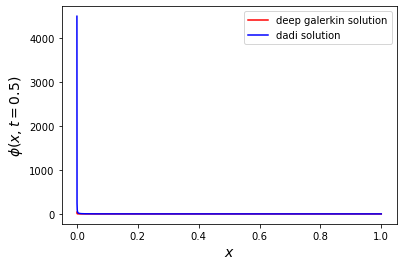

Solution difference:  150667.82201115502


In [144]:
plotStat(0.5, 0.3, 0.01, 0.2, 0.5)

Theta: 0.001  gamma: 0.1  nuB: 0.1  nuA: 0.5  T: 0.5


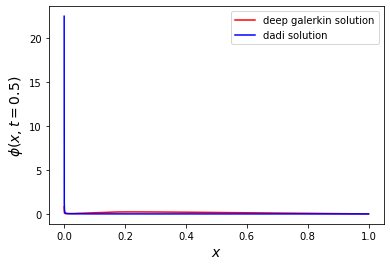

Solution difference:  749.2018780890141


In [145]:
plotStat(0.001, 0.1, 0.1, 0.5, 0.5)

Theta: 0.005  gamma: 0.1  nuB: 0.1  nuA: 0.5  T: 0.9


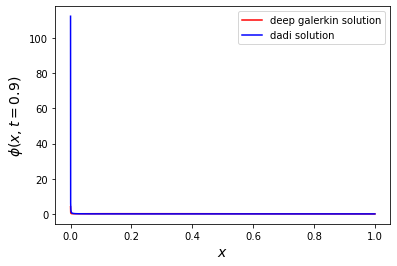

Solution difference:  3761.7896843615963


In [146]:
plotStat(0.005, 0.1, 0.1, 0.5, 0.9)

Theta: 0.005  gamma: 0.3  nuB: 0.1  nuA: 0.5  T: 0.4


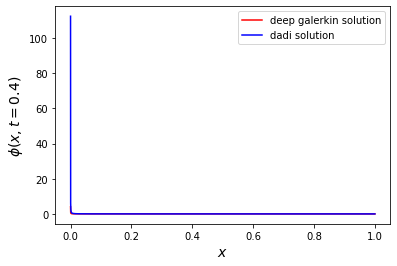

Solution difference:  3760.9683650552934


In [147]:
plotStat(0.005, 0.3, 0.1, 0.5, 0.4)

**Очень большое различие при x около 0. Наверное, ошибка в начальном условии**

### Двумерный случай (в процессе)

In [ ]:
def pydensIntegrate2d(xGrid, params):
    tf.get_logger().setLevel('ERROR')

    nu1 = 0.1
    nu2 = 0.1

    m12 = 0.05
    m21 = 0.01

    gamma1 = 0.1
    gamma2 = 0.1

    eps = 0.0001

    one_pop_pde = {'n_dims': 2,
        'form': lambda u, x, y, t: D(u, t) - 0.5 * (D(D(x*(1-x)*u*1/nu1, x), x) + D(D(y*(1-y)*u*1/nu2, y), y)) + D(gamma1*x*(1-x) + m12*(y-x), x) + D(gamma2*y*(1-y) + m21*(x - y), y),
        'boundary_condition': lambda t: [0, 1], 
        'initial_condition': lambda x, y: 1}

    config = {'pde': one_pop_pde,
            'decay': {'name': 'invtime', 'learning_rate':0.01, 'decay_steps': 100, 'decay_rate': 0.05}}

    s = NumpySampler('u', dim=2)

    model = Solver(config)
    model.fit(batch_size=40, sampler=s, n_iters=500, bar='notebook')
    
    pts = np.array(list(zip(xGrid, xGrid, [T]*len(xGrid))))
    dg = model.solve(pts)

    return dg

In [90]:
dg = pydensIntegrate(xGrid, (gamma, theta, nuB, nuA, T))

Spectrum.from_phi(dg.reshape(1,-1)[0], (10,), (xGrid,))

Spectrum([-- 0.1100000187798688 0.07372478780929943 0.06393805343443172
 0.05955594837735843 0.05609856516538151 0.0520686395080866
 0.04682404433721285 0.04004359084893751 0.03154878118099025 --], folded=False, pop_ids=None)